# Synthetic Data Comparison

In this notebook, different ways to compare the quality of augmented time series are explored.

## Imports and static variables

In [259]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [260]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error
from copy import deepcopy as dc
import seaborn as sns

# own classes
from utilities import load_sequential_time_series, reconstruct_sequential_data, load_complete_time_series, slice_years, train_test_split, extract_features_and_targets, split_data_into_sequences, Scaler, ValidationLossAccumulationCallback, accuracy
from baseline_model.LSTM import LSTMRegression, train_model, LSTMClassification
from baseline_model.TimeSeriesDataset import TimeSeriesDataset
from baseline_model.mean_regressor import MeanRegressor

In [261]:
DATA_FOLDER = Path("../data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"

### Features

In [262]:
MOVING_AVERAGES = [50, 20]
MA_FEATURES = [f'{ma}d MA' for ma in MOVING_AVERAGES]
INCLUDE_MOVING_AVERAGES = False

FEATURES = ['Trend', 'Close', 'Log Close', 'Daily Returns Percent', 'Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5',
       'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200',
       'DTB4WK', 'DTB3', 'DTB6', 'DGS5', 'DGS10', 'Oil', 'Gold', 'DAAA',
       'DBAA', 'GBP', 'JPY', 'CAD', 'CNY', 'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM',
       'MSFT', 'WFC', 'XOM', 'FCHI', 'FTSE', 'GDAXI', 'DJI', 'HSI', 'IXIC',
       'SSEC', 'RUT', 'NYSE', 'TE1', 'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2',
       'DE4', 'DE5', 'DE6', 'CTB3M', 'CTB6M', 'CTB1Y', 'AUD', 'Brent',
       'CAC-F', 'copper-F', 'WIT-oil', 'DAX-F', 'DJI-F', 'EUR', 'FTSE-F',
       'gold-F', 'HSI-F', 'KOSPI-F', 'NASDAQ-F', 'GAS-F', 'Nikkei-F', 'NZD',
       'silver-F', 'RUSSELL-F', 'S&P-F', 'CHF', 'Dollar index-F',
       'Dollar index', 'wheat-F', 'XAG', 'XAU']

# FEATURES = ['Trend', 'AAPL', 'FTSE', 'Volume',
#             'Close', 'Gold', 'JNJ', 'Dollar index']

if INCLUDE_MOVING_AVERAGES:
    FEATURES += MA_FEATURES

### Hyperparams (ish)

In [263]:
BENCHMARK = False
RANDOM_LABEL_PERMUTATION = False


NUM_EPOCHS = 1000
SEQ_LEN = 7
FIRST_SPLIT = 0.8
SECOND_SPLIT = 0.5 

LEARNING_RATE = 0.00005
BATCH_SIZE = 4
HIDDEN_SIZE = 4
NUM_LAYERS = 1

OUTPUT_LOGITS = True
BIDIRECTIONAL = True


In [264]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading data

In [265]:
sp = load_complete_time_series(REAL_DATA_FOLDER / "Processed_S&P.csv")

In [266]:
sp

,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
0,2009-12-31,1115.099976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.03,0.26,-1.08,-1.00,-0.11,-0.08,-0.06,-0.48,0.30,0.39
1,2010-01-04,1132.989990,0.921723,0.016043,NaN,NaN,NaN,NaN,NaN,NaN,...,1.52,3.26,1.61,1.62,-0.57,-0.59,-0.42,3.12,3.91,2.10
2,2010-01-05,1136.520020,-0.375903,0.003116,0.016043,NaN,NaN,NaN,NaN,NaN,...,-0.07,1.96,-0.20,0.31,0.43,0.03,0.12,-0.90,1.42,-0.12
3,2010-01-06,1137.140015,0.996234,0.000546,0.003116,0.016043,NaN,NaN,NaN,NaN,...,0.56,2.15,-0.02,0.07,-0.56,-0.24,-0.17,2.62,2.25,1.77
4,2010-01-07,1141.689941,0.059932,0.004001,0.000546,0.003116,0.016043,NaN,NaN,NaN,...,-0.72,0.94,0.50,0.40,0.58,0.58,0.54,-1.85,0.22,-0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,2017-11-09,2584.620117,-0.017375,-0.003762,0.001444,-0.000189,0.001271,0.184895,0.945954,0.878967,...,-0.24,-0.62,-0.34,-0.27,-0.61,-0.44,-0.45,0.53,-0.26,0.32
1980,2017-11-10,2582.300049,-0.089962,-0.000898,-0.003762,0.001444,-0.000189,-0.214080,0.047654,0.275321,...,-0.27,-0.58,-0.20,-0.17,0.18,-0.07,-0.05,0.70,-0.71,-0.80
1981,2017-11-13,2584.840088,-0.024084,0.000984,-0.000898,-0.003762,0.001444,-0.242743,0.466802,0.774279,...,-0.38,0.72,-0.04,0.10,0.06,0.12,0.11,-1.85,0.83,0.16
1982,2017-11-14,2578.870117,0.070184,-0.002310,0.000984,-0.000898,-0.003762,-0.454319,0.140184,0.379126,...,-0.39,0.17,-0.21,-0.15,-0.70,-0.71,-0.70,1.00,0.01,0.24


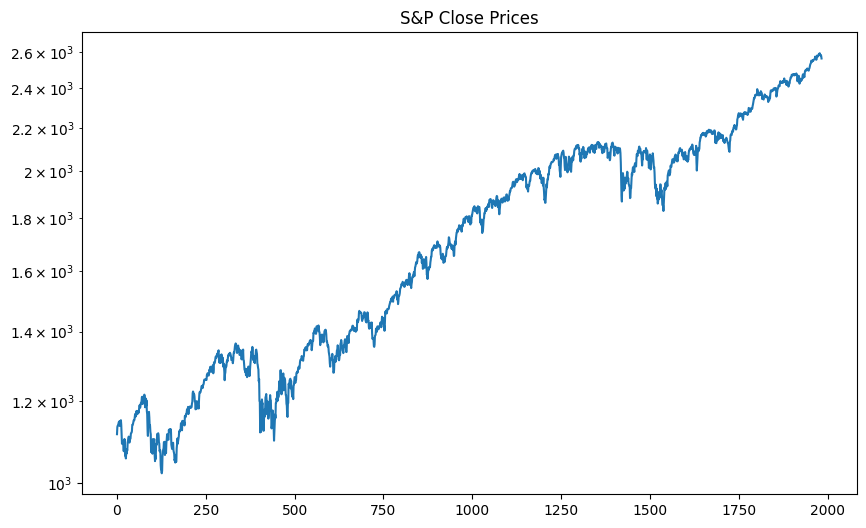

In [267]:
# plot log of close prices
plt.figure(figsize=(10, 6))
plt.plot(sp['Close'])
plt.yscale('log')
plt.title('S&P Close Prices')
plt.show()

## Feature Engineering

In [268]:
# get normal difference
# aapl['Daily Returns'] = aapl['Close'].diff()

# get percaentage difference
sp['Daily Returns Percent'] = sp['Close'].pct_change()

In [269]:
# get log values
sp['Log Close'] = np.log(sp['Close'])

In [270]:
# Create moving averages
if INCLUDE_MOVING_AVERAGES:
    for ma in MOVING_AVERAGES:
        sp[f'{ma}d MA'] = sp['Close'].rolling(window=ma).mean()

In [271]:
# set trend to 1 if daily return > 1, else -1
sp['Trend'] = sp['Daily Returns Percent'].apply(lambda x: 1 if x > 0 else 0)

In [272]:
sp = sp.dropna()
sp = sp[FEATURES]

In [273]:
sp.columns

Index(['Trend', 'Close', 'Log Close', 'Daily Returns Percent', 'Volume', 'mom',
       'mom1', 'mom2', 'mom3', 'ROC_5', 'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10',
       'EMA_20', 'EMA_50', 'EMA_200', 'DTB4WK', 'DTB3', 'DTB6', 'DGS5',
       'DGS10', 'Oil', 'Gold', 'DAAA', 'DBAA', 'GBP', 'JPY', 'CAD', 'CNY',
       'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM', 'MSFT', 'WFC', 'XOM', 'FCHI',
       'FTSE', 'GDAXI', 'DJI', 'HSI', 'IXIC', 'SSEC', 'RUT', 'NYSE', 'TE1',
       'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2', 'DE4', 'DE5', 'DE6', 'CTB3M',
       'CTB6M', 'CTB1Y', 'AUD', 'Brent', 'CAC-F', 'copper-F', 'WIT-oil',
       'DAX-F', 'DJI-F', 'EUR', 'FTSE-F', 'gold-F', 'HSI-F', 'KOSPI-F',
       'NASDAQ-F', 'GAS-F', 'Nikkei-F', 'NZD', 'silver-F', 'RUSSELL-F',
       'S&P-F', 'CHF', 'Dollar index-F', 'Dollar index', 'wheat-F', 'XAG',
       'XAU'],
      dtype='object')

In [274]:
sp.head(25)

,Trend,Close,Log Close,Daily Returns Percent,Volume,mom,mom1,mom2,mom3,ROC_5,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
201,0,1165.900024,7.061249,-0.015877,0.258440,-0.015877,0.007244,0.002027,-0.003641,-0.330834,...,-1.84,-2.59,-1.74,-1.23,1.27,1.66,1.62,-2.58,-4.14,-2.51
202,1,1178.170044,7.071718,0.010524,-0.102184,0.010524,-0.015877,0.007244,0.002027,0.005948,...,1.40,1.03,0.91,0.94,-1.01,-1.29,-1.29,2.52,2.44,0.82
203,1,1180.260010,7.073490,0.001774,-0.080036,0.001774,0.010524,-0.015877,0.007244,0.549488,...,-0.98,-3.69,-0.53,0.09,0.64,0.28,0.32,-3.09,-3.26,-1.55
206,1,1185.640015,7.078038,0.000017,-0.004193,0.000017,0.002147,0.002389,0.001774,1.693112,...,-0.52,2.42,-0.23,0.00,1.17,0.79,0.79,3.65,0.85,-0.04
207,0,1182.449951,7.075344,-0.002691,0.031399,-0.002691,0.000017,0.002147,0.002389,0.363267,...,0.03,-2.97,-0.26,-0.34,0.47,0.60,0.57,0.61,-1.22,-1.09
208,1,1183.780029,7.076468,0.001125,-0.012042,0.001125,-0.002691,0.000017,0.002147,0.298241,...,0.86,2.02,-0.84,0.04,-0.53,-1.12,-1.07,2.06,1.95,1.44
211,1,1193.569946,7.084704,0.007759,-0.063688,0.007759,0.000947,-0.000439,0.001125,0.668831,...,0.55,1.16,1.99,0.82,-1.25,-0.76,-0.75,-1.56,1.18,0.43
212,1,1197.959961,7.088375,0.003678,0.206735,0.003678,0.007759,0.000947,-0.000439,1.311684,...,2.00,-1.61,0.43,0.38,-0.73,-0.35,-0.31,-0.11,-0.36,-0.65
213,1,1221.060059,7.107475,0.019283,0.220768,0.019283,0.003678,0.007759,0.000947,3.149236,...,1.04,6.58,2.22,1.77,-1.47,-0.81,-0.78,3.67,6.08,3.27
214,1,1225.849976,7.111390,0.003923,-0.010185,0.003923,0.019283,0.003678,0.007759,3.599375,...,0.11,2.71,0.55,0.29,0.42,0.91,0.88,1.18,1.40,0.08


## Preprocessing

In [275]:
sp_np = sp.to_numpy()

In [276]:
sp_np[:10]

array([[ 0.00000000e+00,  1.16590002e+03,  7.06124862e+00,
        -1.58772507e-02,  2.58439793e-01, -1.58772507e-02,
         7.24374500e-03,  2.02748480e-03, -3.64138620e-03,
        -3.30833919e-01,  4.43680724e-01,  1.58578668e+00,
         2.29166983e+00,  1.16830357e+03,  1.15644663e+03,
         1.13226929e+03,  1.12150254e+03,  1.40000000e-01,
         1.40000000e-01,  1.80000000e-01,  1.11000000e+00,
         2.50000000e+00, -4.20178184e-02, -2.06619126e-02,
         4.70000000e+00,  5.75000000e+00, -1.20133686e-02,
         4.23658230e-03,  1.56027253e-02,  6.02936300e-05,
        -2.67610008e-02, -2.98972858e-02, -1.10769231e-02,
        -8.92577500e-03, -1.33508373e-02, -2.78853602e-02,
        -1.28669878e-02, -1.75014487e-02, -7.12741640e-03,
        -6.72182810e-03, -3.98057620e-03, -1.48128947e-02,
         1.25418566e-02, -1.76202956e-02,  1.57774598e-02,
        -2.25028951e-02, -1.94753991e-02,  2.36000000e+00,
         2.36000000e+00,  2.32000000e+00,  0.00000000e+0

In [277]:
sp_train, sp_test = train_test_split(sp_np, FIRST_SPLIT)
sp_test, sp_val = train_test_split(sp_test, SECOND_SPLIT)

In [278]:
# account for moving averages
if INCLUDE_MOVING_AVERAGES:
    print("Moving Averages included")
    sp_train = sp_train[max(MOVING_AVERAGES):]
    sp_val = sp_val[max(MOVING_AVERAGES):]

print("Moving Averages NOT included")

Moving Averages NOT included


In [279]:
scaler = Scaler(sp_train, scale_features_individually=False)

In [280]:
sp_train_scaled = scaler.scale_data(sp_train)
sp_test_scaled = scaler.scale_data(sp_test)
sp_val_scaled = scaler.scale_data(sp_val)

In [281]:
sp_train_seq_scaled = split_data_into_sequences(sp_train_scaled, SEQ_LEN)
sp_test_seq_scaled = split_data_into_sequences(sp_test_scaled, SEQ_LEN)
sp_val_seq_scaled = split_data_into_sequences(sp_val_scaled, SEQ_LEN)

Shape of the data after splitting into sequences: (885, 7, 85)
Shape of the data after splitting into sequences: (105, 7, 85)
Shape of the data after splitting into sequences: (106, 7, 85)


In [282]:
criterion = nn.BCEWithLogitsLoss()

In [283]:
def create_data_loader(X_train, y_train, X_test, y_test, X_val, y_val):
    # get baseline performance
    train_dataset = TimeSeriesDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

    test_dataset = TimeSeriesDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    val_dataset = TimeSeriesDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader, val_loader

In [284]:
def train_model_once(no_features, train_loader, val_loader):
    # create and train model
    model = LSTMClassification(
        device=device,
        batch_size = BATCH_SIZE,
        input_size=no_features,
        hidden_size=HIDDEN_SIZE,
        num_stacked_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        output_logits=OUTPUT_LOGITS
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    _, _, _, _, model = train_model(model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                device=device,
                verbose=False)
    
    return model

In [285]:
def get_test_performance(model, X_test, y_test):
    with torch.inference_mode(): 
        test_logits = model(X_test.to(device)) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes

        test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
        test_loss = criterion(test_logits, y_test).item()

    return test_acc, test_loss

In [286]:
# get train, test and validation data
X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets(sp_train_seq_scaled, sp_test_seq_scaled, sp_val_seq_scaled)

In [287]:
if BENCHMARK:
        
    results = pd.DataFrame(columns=['Feature', 'Metric', 'Value'])
    test_accs = []
    test_losses = []

    for i in range(5):
        # get baseline performance
        train_loader, test_loader, val_loader = create_data_loader(X_train, y_train, X_test, y_test, X_val, y_val)
        trained_model = train_model_once(len(FEATURES)-1, train_loader, val_loader)
        test_acc, test_loss = get_test_performance(trained_model, X_test, y_test)

        test_accs.append(test_acc)
        test_losses.append(test_loss)

    # save baseline performance
    results = pd.concat([results, pd.DataFrame([{'Feature': 'baseline', 'Metric': 'Accuracy', 'Value': np.mean(np.array(test_accs))}])], ignore_index=True)
    results = pd.concat([results, pd.DataFrame([{'Feature': 'baseline', 'Metric': 'Loss', 'Value': np.mean(np.array(test_losses))}])], ignore_index=True)

    for feature in FEATURES[1:]:

        print(f'Current feature: {feature}')
        test_accs = []
        test_losses = []

        for i in range(5):
            print(f'Iteration {i+1}')

            # random permutation of one specific feature
            feature_index = FEATURES.index(feature)-1 # -1 because of the trend feature
            permuted_X_test = dc(X_test)
            permuted_X_test[:, :, feature_index] = torch.tensor(np.random.permutation(permuted_X_test[:, :, feature_index]), dtype=torch.float32)

            train_loader, test_loader, val_loader = create_data_loader(X_train, y_train, permuted_X_test, y_test, X_val, y_val)
            trained_model = train_model_once(len(FEATURES)-1, train_loader, val_loader)
            test_acc, test_loss = get_test_performance(trained_model, permuted_X_test, y_test)

            test_accs.append(test_acc)
            test_losses.append(test_loss)

        # save performance
        results = pd.concat([results, pd.DataFrame([{'Feature': feature, 'Metric': 'Accuracy', 'Value': np.mean(np.array(test_accs))}])], ignore_index=True)
        results = pd.concat([results, pd.DataFrame([{'Feature': feature, 'Metric': 'Loss', 'Value': np.mean(np.array(test_accs))}])], ignore_index=True)

else:
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    val_dataset = TimeSeriesDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    criterion = nn.BCEWithLogitsLoss()
    val_losses = []
    val_accs = []
    train_losses = []
    train_accs = []

    model = LSTMClassification(
            device=device,
            batch_size = BATCH_SIZE,
            input_size=X_train.shape[2], # number of features
            hidden_size=HIDDEN_SIZE,
            num_stacked_layers=NUM_LAYERS,
            bidirectional=BIDIRECTIONAL,
            output_logits=OUTPUT_LOGITS
        ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses, train_accs, val_losses, val_accs, model = train_model(model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion,
                        optimizer=optimizer,
                        device=device,
                        verbose=True)

Epoch: 1
Training Loss: 0.6938270917534828
Validation Loss: 0.6930639125682689
Validation Accuracy: 51.851851851851855
**************************************************
Epoch: 2
Training Loss: 0.6928610616922378
Validation Loss: 0.6928808490435282
Validation Accuracy: 51.851851851851855
**************************************************
Epoch: 3
Training Loss: 0.6920230519771576
Validation Loss: 0.6928090740133215
Validation Accuracy: 50.925925925925924
**************************************************
Epoch: 4
Training Loss: 0.6913031527400016
Validation Loss: 0.6928166901623761
Validation Accuracy: 50.925925925925924
INFO: Validation loss did not improve in epoch 4
**************************************************
Epoch: 5
Training Loss: 0.6906840845942497
Validation Loss: 0.6928784781032138
Validation Accuracy: 51.851851851851855
INFO: Validation loss did not improve in epoch 5
**************************************************
Epoch: 6
Training Loss: 0.6901496717333794
Validatio

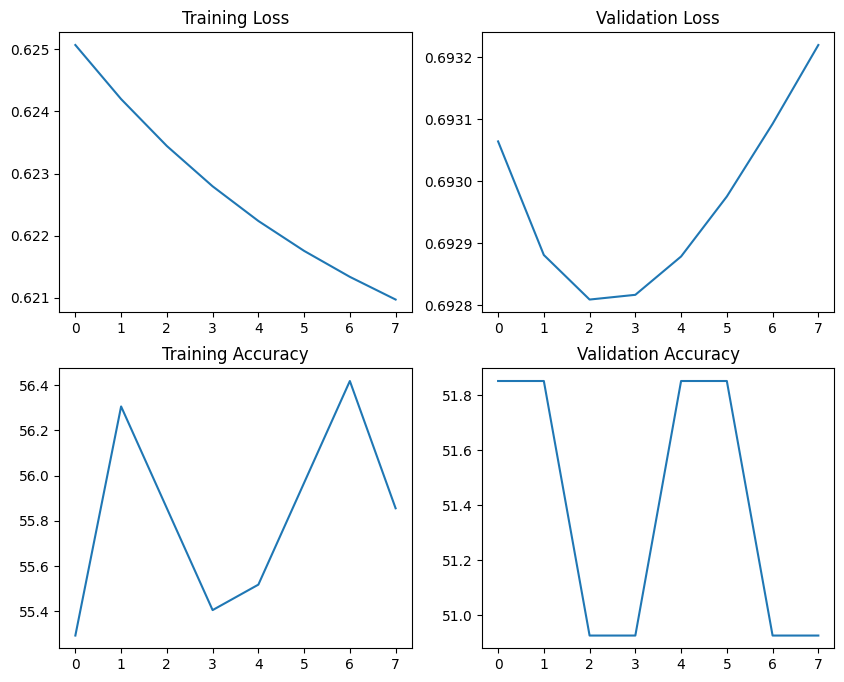

In [288]:
if BENCHMARK:

    # Erstelle eine Pivot-Tabelle, um die Daten besser zu handhaben
    pivot_df = results.pivot(index='Feature', columns='Metric', values='Value')

    # Sortiere die Daten nach den Accuracy-Werten
    pivot_df = pivot_df.sort_values(by='Accuracy', ascending=False)

    # Anzahl der Features
    num_features = len(pivot_df.index)

    # Initialisiere die Hauptfigur und die Hauptachse
    fig, ax1 = plt.subplots(figsize=(10, num_features * 0.4))  # Höhe proportional zur Anzahl der Features

    # Balkenbreite
    bar_height = 0.35

    # Positionen der Balken
    r1 = np.arange(len(pivot_df.index))
    r2 = [x + bar_height for x in r1]

    # Balken für Accuracy
    accuracy_bars = ax1.barh(r1, pivot_df['Accuracy'], color='skyblue', height=bar_height, label='Accuracy')

    # Zweite y-Achse für Loss
    ax2 = ax1.twiny()
    loss_bars = ax2.barh(r2, pivot_df['Loss'], color='salmon', height=bar_height, label='Loss')

    # Titel und Achsenbeschriftungen hinzufügen
    ax1.set_title('Feature Importance: Accuracy and Loss', fontsize=16)
    ax1.set_ylabel('Feature', fontsize=14)
    ax1.set_xlabel('Accuracy', fontsize=14, color='skyblue')
    ax2.set_xlabel('Loss', fontsize=14, color='salmon')

    # y-Ticks setzen
    ax1.set_yticks([r + bar_height/2 for r in range(len(pivot_df.index))])
    ax1.set_yticklabels(pivot_df.index)

    # Achsenbeschriftungen einfärben
    ax1.tick_params(axis='x', labelcolor='skyblue')
    ax2.tick_params(axis='x', labelcolor='salmon')

    # Legenden kombinieren
    bars = accuracy_bars + loss_bars
    labels = [bar.get_label() for bar in bars]
    ax1.legend(bars, labels, loc='lower right')

    # Diagramm anzeigen
    plt.tight_layout()
    plt.show()

else:
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Diagramm 1 (oben links)
    axs[0, 0].plot(train_losses, label="BCELoss")
    axs[0, 0].set_title('Training Loss')

    axs[0, 1].plot(val_losses, label="BCELoss")
    axs[0, 1].set_title('Validation Loss')

    axs[1, 0].plot(train_accs, label="Accuracy")
    axs[1, 0].set_title('Training Accuracy')

    axs[1, 1].plot(val_accs, label="Accuracy")
    axs[1, 1].set_title('Validation Accuracy')